<a href="https://colab.research.google.com/github/hwanin99/NLP_Study/blob/main/12_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D(Sentiment%20Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감정 분석(Sentiment Analysis)

* 감정 분석은 텍스트에 등장하는 단어들을 통해 어떤 감정이 드러나는지 분석하는 기법
* 감정 분석은 오피니언 마이닝으로도 불리며, 텍스트에 담긴 의견, 태도 등을 알아보는데 유용한 기법
* 감정 분석을 하기 위해선 미리 정의된 감정 어휘 사전이 필요
* 감정 어휘 사전에 포함된 어휘가 텍스트에 얼마나 분포하는지에 따라 해당 텍스트의 감정이 좌우
* 토픽 모델링이 텍스트의 주제를 찾아낸다면, 감정 분석은 텍스트의 의견을 찾아냄
* 텍스트는 주제(토픽)와 의견(감정)의 결합으로 이루어졌다고 볼 수 있음

![2655364B5925AC9606[1].png](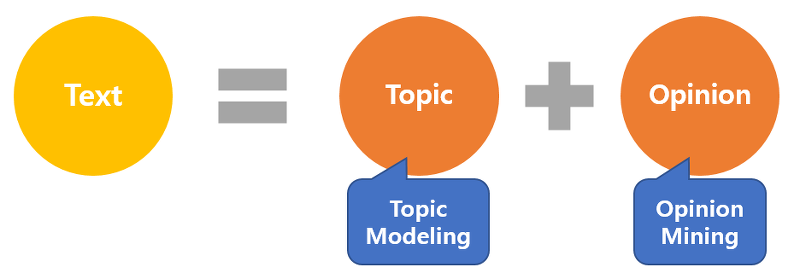)

* 감정 분석은 SNS, 리뷰 분석에 유용하게 사용할 수 있음
* 특정 이슈에 대한 사람들의 감정을 실시간으로 분석한다면, 그에 대해 신속하게 대처 가능

* 파이썬으로 감정 분석하는 방법은 크게 두 가지로 구분
  + 감정 어휘 사전을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  + 기계학습을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 라벨이 포함되어 있어야 하며,  
이를 인공 신경망, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

## 감정 어휘 사전을 이용한 감정 상태 분류

### 감정 사전 준비

*   감정 사전 라이브러리를 설치
*   afinn은 영어에 대한 긍정, 부정에 대한 감정 사전을 제공


In [ ]:
!pip install afinn

### 데이터 준비

1.   사용할 데이터를 구성 
2.   데이터는 사이킷런에 내장되어 있는 뉴스그룹 데이터를 이용

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsdata=fetch_20newsgroups(subset='train')
newsdata.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 감정 상태 분류 및 시각화

*   감정 사전을 구성하고 감정 스코어를 측정
*   afinn 라이브러리는 감정 사전과 더불어 편리하게 감정가를 계산할 수 있는 함수를 제공

In [3]:
from afinn import Afinn

afinn=Afinn()
for i in range(10):
  print(afinn.score(newsdata.data[i]))

7.0
11.0
16.0
5.0
-23.0
-25.0
7.0
3.0
16.0
-20.0


*   모든 뉴스에 대한 감정을 시각화
*   긍정과 부정에 대한 갯수를 시각화



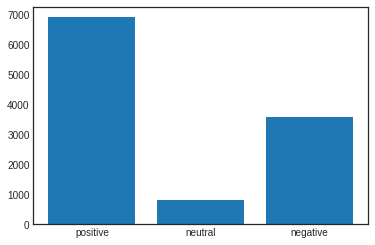

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

positive=0
neutral=0
negative=0

for i in newsdata.data:
  score=afinn.score(i)
  if score>0:
    positive+=1
  elif score==0:
    neutral+=1
  else:
    negative+=1

plt.bar(np.arange(3),[positive,neutral,negative])
plt.xticks(np.arange(3),['positive','neutral','negative'])
plt.show()

## 기계학습을 이용한 감정 분석

#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [6]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 네이버 영화 리뷰 데이터

* 참고: https://wikidocs.net/44249

#### 데이터 로드

* 데이터를 웹에서 바로 받아오기 위해 `urllib.request` 사용
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
* 받아온 데이터를 `dataframe`으로 변환하고 데이터를 확인



In [7]:
train_file=urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file=urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data=pd.read_table(train_file)
test_data=pd.read_table(test_file)

train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


#### 중복 및 결측치 처리

*   데이터 개수 확인
*   데이터에 중복이 존재한다면 이를 제거



In [8]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

train_data.drop_duplicates(subset=['document'],inplace=True)

146182
2


In [9]:
print(train_data.isnull().sum())

train_data=train_data.dropna(how='any')

id          0
document    1
label       0
dtype: int64


#### 데이터 정제



*   데이터에서 한글과 공백을 제외하고 모두 제거



In [10]:
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", '')

train_data[:10]

<ipython-input-10-f6d4c7d9a3ce>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", '')


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [11]:
train_data['document'].replace('',np.nan,inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


In [12]:
train_data=train_data.dropna(how='any')
print(len(train_data))

145791


In [13]:
test_data.drop_duplicates(subset=['document'],inplace=True)
test_data['document']=test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test_data['document'].replace('',np.nan,inplace=True)
test_data=test_data.dropna(how='any')

<ipython-input-13-6d7e9c8e374e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document']=test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')


#### 토큰화 및 불용어 제거



* 단어들을 분리하고 불용어를 제거함
* 불용어 사전: `'의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'`



In [14]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [15]:
mecab=Mecab()

x_train=[]
for sentence in train_data['document']:
  x_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [16]:
print(x_train[:1])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']]


In [17]:
x_test=[]
for sentence in train_data['document']:
  x_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [18]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)

#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [19]:
threshold=3
words_cnt=len(tokenizer.word_index)
rare_cnt=0
words_freq=0
rare_freq=0

for key,value in tokenizer.word_counts.items():
  words_freq=words_freq+value

  if value<threshold:
    rare_cnt+=1
    rare_freq=rare_freq+value

print('전체 단어 수:',words_cnt)
print('빈도가 {} 이하인 희귀 단어 수: {}'.format(threshold-1,rare_cnt))
print('희귀 단어 비율: {}'.format((rare_cnt/words_cnt)*100))
print('희귀 단어 등장 빈도 비율: {}'.format((rare_freq/words_freq)*100))

전체 단어 수: 49946
빈도가 2 이하인 희귀 단어 수: 28320
희귀 단어 비율: 56.70123733632323
희귀 단어 등장 빈도 비율: 1.7606762208782198


In [20]:
vocab_size=words_cnt-rare_cnt+2
print(vocab_size)

21628


In [21]:
tokenizer=Tokenizer(vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train=tokenizer.texts_to_sequences(x_train)
x_test=tokenizer.texts_to_sequences(x_test)

In [22]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [23]:
drop_train=[index for index,sentence in enumerate(x_train) if len(sentence) < 1]

x_train=np.delete(x_train,drop_train,axis=0)
y_train=np.delete(y_train,drop_train,axis=0)

print(len(x_train))
print(len(y_train))

145380
145380


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


#### 패딩



*   리뷰의 전반적인 길이를 확인
*   모델의 입력을 위해 동일한 길이로 맞춰줌



In [24]:
print('리뷰 최대 길이:',max(len(l) for l in x_train))
print('리뷰 평균 길이:',sum(map(len,x_train))/len(x_train))

리뷰 최대 길이: 83
리뷰 평균 길이: 13.801382583574082


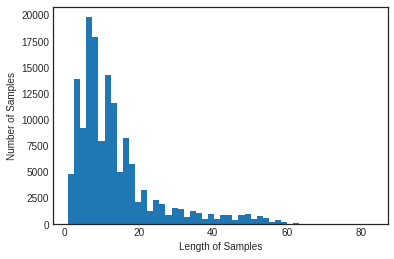

In [25]:
plt.hist([len(s) for s in x_train],bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [26]:
max_len=60

In [27]:
x_train=pad_sequences(x_train,maxlen=max_len)
x_test=pad_sequences(x_test,maxlen=max_len)

#### 모델 구축 및 학습

*   감정 상태 분류 모델을 선언하고 학습
*   모델은 일반적인 LSTM 모델을 사용



In [28]:
from tensorflow.keras.layers import Embedding,Dense,LSTM
from tensorflow.keras.models import Sequential

In [29]:
model=Sequential()

model.add(Embedding(vocab_size,100))
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2162800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,280,177
Trainable params: 2,280,177
Non-trainable params: 0
_________________________________________________________________


In [30]:
history=model.fit(x_train,y_train,epochs=15,batch_size=60,validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 53s 23ms/step - loss: 0.4083 - acc: 0.8128 - val_loss: 0.3724 - val_acc: 0.8342
Epoch 2/15
1939/1939 [==============================] - 19s 10ms/step - loss: 0.3383 - acc: 0.8541 - val_loss: 0.3428 - val_acc: 0.8489
Epoch 3/15
1939/1939 [==============================] - 18s 9ms/step - loss: 0.3074 - acc: 0.8698 - val_loss: 0.3288 - val_acc: 0.8570
Epoch 4/15
1939/1939 [==============================] - 17s 9ms/step - loss: 0.2842 - acc: 0.8828 - val_loss: 0.3208 - val_acc: 0.8618
Epoch 5/15
1939/1939 [==============================] - 17s 9ms/step - loss: 0.2636 - acc: 0.8939 - val_loss: 0.3248 - val_acc: 0.8619
Epoch 6/15
1939/1939 [==============================] - 17s 9ms/step - loss: 0.2450 - acc: 0.9036 - val_loss: 0.3321 - val_acc: 0.8601
Epoch 7/15
1939/1939 [==============================] - 16s 8ms/step - loss: 0.2266 - acc: 0.9119 - val_loss: 0.3385 - val_acc: 0.8629
Epoch 8/15
1939/1939 [==============================]

#### 시각화

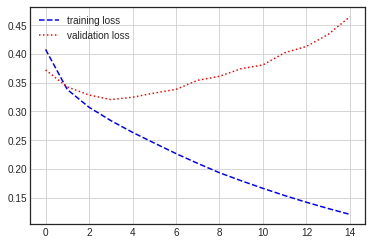

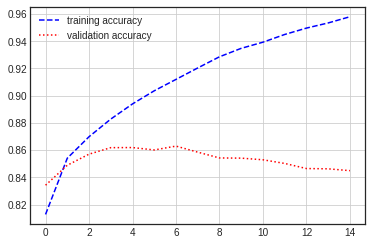

In [31]:
hist_dic=history.history
loss=hist_dic['loss']
val_loss=hist_dic['val_loss']
acc=hist_dic['acc']
val_acc=hist_dic['val_acc']

plt.plot(loss,'b--',label='training loss')
plt.plot(val_loss,'r:',label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--',label='training accuracy')
plt.plot(val_acc,'r:',label='validation accuracy')
plt.legend()
plt.grid()

plt.show()

#### 감정 예측

In [32]:
def sentiment_predict(new_sentence):
  new_token=[word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences=tokenizer.texts_to_sequences([new_token])
  new_pad=pad_sequences(new_sequences,maxlen=max_len)
  score=float(model.predict(new_pad))

  if score>0.5:
    print('{} -> 긍정({:.2f}%)'.format(new_sentence,score*100))
  else:
    print('{} -> 부정({:.2f}%)'.format(new_sentence,(1-score)*100))

In [33]:
sentiment_predict('정말 재미있고 흥미진진 했어요.')
sentiment_predict('어떻게 이렇게 지루하고 재미없죠?')
sentiment_predict('배우 연기력이 대박입니다.')
sentiment_predict('분위가가 어둡고 스토리가 복잡해요.')

1/1 [==============================] - 0s 493ms/step
정말 재미있고 흥미진진 했어요. -> 긍정(99.88%)
1/1 [==============================] - 0s 22ms/step
어떻게 이렇게 지루하고 재미없죠? -> 부정(99.52%)
1/1 [==============================] - 0s 23ms/step
배우 연기력이 대박입니다. -> 긍정(91.98%)
1/1 [==============================] - 0s 23ms/step
분위가가 어둡고 스토리가 복잡해요. -> 긍정(91.34%)


### 네이버 쇼핑 리뷰 데이터

* 참고: https://wikidocs.net/94600

#### 데이터 로드
* https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt

In [34]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt',filename='shopping.txt')

('shopping.txt', <http.client.HTTPMessage at 0x7f92fffd55b0>)

In [35]:
total_data=pd.read_table('shopping.txt',names=['ratings','reviews'])
print(len(total_data))

200000


In [36]:
total_data[:10]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


#### 훈련 데이터와 테스트 데이터 분리

In [37]:
total_data['label']=np.select([total_data.ratings > 3],[1],default=0)
total_data[:10]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [38]:
total_data['ratings'].nunique(),total_data['reviews'].nunique(),total_data['label'].nunique()

(4, 199908, 2)

In [39]:
total_data.drop_duplicates(subset=['reviews'],inplace=True)
print(len(total_data))

199908


In [40]:
from sklearn.model_selection import train_test_split

train_data,test_data=train_test_split(total_data,test_size=0.25,random_state=111)
print(len(train_data))
print(len(test_data))

149931
49977


#### 레이블의 분포 확인

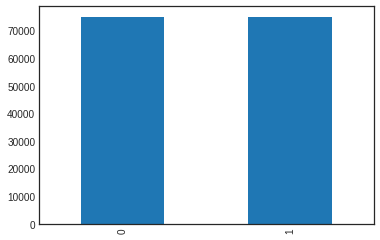

In [41]:
train_data['label'].value_counts().plot(kind='bar');

In [42]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,74974
1,1,74957


#### 데이터 정제

In [43]:
train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data['reviews'].replace('',np.nan,inplace=True)
print(len(train_data))

<ipython-input-43-9d171547e480>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')


149931


In [44]:
test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test_data['reviews'].replace('',np.nan,inplace=True)
print(len(test_data))

49977


<ipython-input-44-499781557df3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews']=test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')


#### 토큰화 및 불용어 제거

* 불용어 사전: `'도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게'`

In [45]:
stopwords=['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [46]:
mecab=Mecab()

train_data['reviews']=train_data['reviews'].apply(mecab.morphs)
train_data['reviews']=train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

In [47]:
test_data['reviews']=test_data['reviews'].apply(mecab.morphs)
test_data['reviews']=test_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

In [64]:
x_train=train_data['reviews'].values
y_train=train_data['label'].values
x_test=test_data['reviews'].values
y_test=test_data['label'].values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(149931,)
(149931,)
(49977,)
(49977,)


#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [65]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)

In [66]:
threshold=3
words_cnt=len(tokenizer.word_index)
rare_cnt=0
words_freq=0
rare_freq=0

for key,value in tokenizer.word_counts.items():
  words_freq=words_freq+value

  if value<threshold:
    rare_cnt+=1
    rare_freq=rare_freq+value

print('전체 단어 수:',words_cnt)
print('빈도가 {} 이하인 희귀 단어 수: {}'.format(threshold-1,rare_cnt))
print('희귀 단어 비율: {}'.format((rare_cnt/words_cnt)*100))
print('희귀 단어 등장 빈도 비율: {}'.format((rare_freq/words_freq)*100))

전체 단어 수: 40060
빈도가 2 이하인 희귀 단어 수: 23110
희귀 단어 비율: 57.688467299051425
희귀 단어 등장 빈도 비율: 1.2179007170085354


In [67]:
vocab_size=words_cnt-rare_cnt+2
print(vocab_size)

16952


In [68]:
tokenizer=Tokenizer(vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train=tokenizer.texts_to_sequences(x_train)
x_test=tokenizer.texts_to_sequences(x_test)

In [69]:
print(x_train[:2])

[[5405, 3, 258, 15, 1424, 102], [86, 108, 263, 98, 10, 26, 17, 2, 612, 275, 208, 560, 1566, 3188, 1573, 344, 212, 264, 561, 738, 1205, 80, 38, 148, 139, 5555, 1610, 98, 542, 49, 58, 5055, 2, 77]]


In [70]:
print(x_test[:2])

[[12, 71, 2, 45, 346, 73, 24, 23, 4606, 243, 2], [978, 2245, 2780, 725, 730, 9, 103, 53, 19, 49, 85]]


#### 패딩

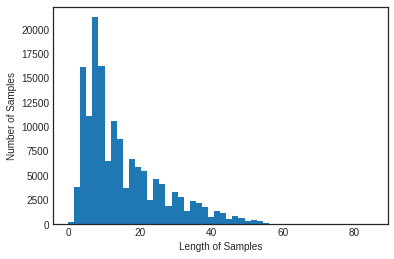

In [71]:
plt.hist([len(s) for s in x_train],bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [72]:
max_len=60

In [73]:
x_train=pad_sequences(x_train,maxlen=max_len)
x_test=pad_sequences(x_test,maxlen=max_len)

#### 모델 구축 및 학습

In [74]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding,Dense,GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [75]:
model=Sequential()

model.add(Embedding(vocab_size,100))
model.add(GRU(128))
model.add(Dense(1,activation='sigmoid'))

In [76]:
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)

In [77]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,
                  epochs=15,
                  callbacks=[es,mc],
                  batch_size=60,
                  validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2899 - acc: 0.8885
Epoch 1: val_acc improved from -inf to 0.90629, saving model to best_model.h5
2000/2000 [==============================] - 47s 22ms/step - loss: 0.2899 - acc: 0.8885 - val_loss: 0.2590 - val_acc: 0.9063
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2278 - acc: 0.9182
Epoch 2: val_acc improved from 0.90629 to 0.91610, saving model to best_model.h5
2000/2000 [==============================] - 18s 9ms/step - loss: 0.2278 - acc: 0.9182 - val_loss: 0.2327 - val_acc: 0.9161
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2058 - acc: 0.9262
Epoch 3: val_acc improved from 0.91610 to 0.91933, saving model to best_model.h5
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2058 - acc: 0.9262 - val_loss: 0.2249 - val_acc: 0.9193
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1927 - acc: 0.9319
Epoch 4: val_ac

In [78]:
loaded_model=load_model('best_model.h5')
loaded_model.evaluate(x_test,y_test)

1562/1562 [==============================] - 7s 4ms/step - loss: 0.2156 - acc: 0.9230


[0.21558073163032532, 0.9230045676231384]

#### 시각화

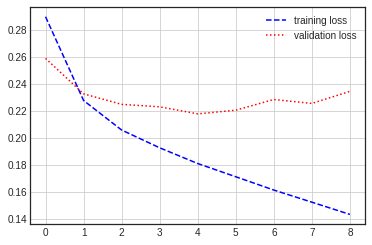

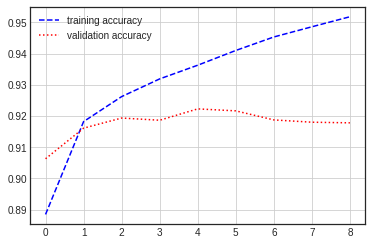

In [79]:
hist_dic=history.history
loss=hist_dic['loss']
val_loss=hist_dic['val_loss']
acc=hist_dic['acc']
val_acc=hist_dic['val_acc']

plt.plot(loss,'b--',label='training loss')
plt.plot(val_loss,'r:',label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--',label='training accuracy')
plt.plot(val_acc,'r:',label='validation accuracy')
plt.legend()
plt.grid()

plt.show()

#### 감정 예측

In [80]:
def sentiment_predict(new_sentence):
  new_token=[word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences=tokenizer.texts_to_sequences([new_token])
  new_pad=pad_sequences(new_sequences,maxlen=max_len)
  score=float(loaded_model.predict(new_pad))

  if score>0.5:
    print('{} -> 긍정({:.2f}%)'.format(new_sentence,score*100))
  else:
    print('{} -> 부정({:.2f}%)'.format(new_sentence,(1-score)*100))

In [81]:
sentiment_predict('처음 써봤는데 대박 좋아요.')
sentiment_predict('원래 배송이 이렇게 늦나요?')
sentiment_predict('좋은거 인정! 추가 구매 의향 있습니다.')
sentiment_predict('이건 정말 리뷰 쓰는게 아깝네요.')

1/1 [==============================] - 0s 385ms/step
처음 써봤는데 대박 좋아요. -> 긍정(96.73%)
1/1 [==============================] - 0s 21ms/step
원래 배송이 이렇게 늦나요? -> 부정(94.58%)
1/1 [==============================] - 0s 21ms/step
좋은거 인정! 추가 구매 의향 있습니다. -> 긍정(94.74%)
1/1 [==============================] - 0s 22ms/step
이건 정말 리뷰 쓰는게 아깝네요. -> 부정(91.57%)
